In [3]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [4]:
# Cell 2: Load the dataset from the CSV file
# (Ensure that the file path is correct)
df = pd.read_csv('test_OT.csv')
print("Dataset Loaded. Shape:", df.shape)
# Display the first few rows to inspect actual columns/parameters
print(df.head())

Dataset Loaded. Shape: (7490, 13)
   file_size_KB  chunk_size_KB  access_count  access_count_label  avg_read_KB  \
0        512000          16384            30                   3        278.3   
1        512000            512            10                   1        183.2   
2        204800            128            22                   3         56.3   
3       1024000          16384            22                   3        219.7   
4        512000             64            15                   2         23.4   

   avg_write_KB  max_read_KB  max_write_KB  read_ops  write_ops  \
0         249.5          501           508        20         10   
1         378.8          277           465         5          5   
2          35.0          126            41        20          2   
3          42.5          490            57        20          2   
4          41.6           48            65         5         10   

   throughput_KBps  combination  OT  
0        703786.20   512000 | 3   1  


In [5]:
# Cell 3: Explore the dataset: list columns, data types, and basic statistics
print("Columns in dataset:", df.columns.tolist())

print("\nDataset Information:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())

# Optional: Show the distribution of the target column OT
print("\nOT value counts:")
print(df['OT'].value_counts())

Columns in dataset: ['file_size_KB', 'chunk_size_KB', 'access_count', 'access_count_label', 'avg_read_KB', 'avg_write_KB', 'max_read_KB', 'max_write_KB', 'read_ops', 'write_ops', 'throughput_KBps', 'combination', 'OT']

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7490 entries, 0 to 7489
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   file_size_KB        7490 non-null   int64  
 1   chunk_size_KB       7490 non-null   int64  
 2   access_count        7490 non-null   int64  
 3   access_count_label  7490 non-null   int64  
 4   avg_read_KB         7490 non-null   float64
 5   avg_write_KB        7490 non-null   float64
 6   max_read_KB         7490 non-null   int64  
 7   max_write_KB        7490 non-null   int64  
 8   read_ops            7490 non-null   int64  
 9   write_ops           7490 non-null   int64  
 10  throughput_KBps     7490 non-null   float64
 11  combinatio

In [6]:
# Cell 4: Preprocessing
# Check for missing values in the key columns and drop rows with missing values.
print("Missing values in each column:\n", df.isnull().sum())

# Drop rows with missing values in the key columns: adjust these column names if they differ in your dataset.
df = df.dropna(subset=['file_size_KB', 'chunk_size_KB', 'OT'])
print("\nAfter dropping missing values, new shape:", df.shape)

Missing values in each column:
 file_size_KB          0
chunk_size_KB         0
access_count          0
access_count_label    0
avg_read_KB           0
avg_write_KB          0
max_read_KB           0
max_write_KB          0
read_ops              0
write_ops             0
throughput_KBps       0
combination           0
OT                    0
dtype: int64

After dropping missing values, new shape: (7490, 13)


In [7]:
# Cell 5: Identify the available (candidate) chunk sizes.
# We assume that the column is named 'chunk_size'; if it’s different, update accordingly.
unique_chunks = np.sort(df['chunk_size_KB'].unique())
print("Unique chunk sizes in the dataset:", unique_chunks)

Unique chunk sizes in the dataset: [    64    128    256    512   1024   2048   4096   8192  16384  32768
  65536 131072]


In [8]:
# Cell 6: Define features and target for the model.
# Here, we use 'file_size' and 'chunk_size' as predictors and 'OT' as the binary target.
X = df[['file_size_KB', 'chunk_size_KB']]
y = df['OT']

# Optionally, check the first few rows of your features and target.
print("Features (first 5 rows):")
print(X.head())
print("\nTarget (first 5 rows):")
print(y.head())

Features (first 5 rows):
   file_size_KB  chunk_size_KB
0        512000          16384
1        512000            512
2        204800            128
3       1024000          16384
4        512000             64

Target (first 5 rows):
0    1
1    0
2    0
3    0
4    0
Name: OT, dtype: int64


In [9]:
# Cell 7: Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (5992, 2)
Test set shape: (1498, 2)


In [10]:
# Cell 8: Train a Random Forest Classifier.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
print("Random Forest model trained.")

Random Forest model trained.


In [11]:
# Cell 9: Evaluate the model on the test set.
y_pred = rf_model.predict(X_test)
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy on test set: 0.6388518024032043

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.97      0.78       979
           1       0.26      0.02      0.04       519

    accuracy                           0.64      1498
   macro avg       0.46      0.49      0.41      1498
weighted avg       0.52      0.64      0.52      1498

Confusion Matrix:
 [[945  34]
 [507  12]]


In [12]:
# Cell 10: Define a function to determine the optimal chunk size for a given file size.
def find_optimal_chunk_size(model, file_size, candidate_chunks, tolerance=1e-4):
    """
    For a given file size, this function iterates over candidate chunk sizes,
    predicts the probability of high throughput (OT=1) for each chunk using the model,
    and returns the chunk size with the highest probability.

    If multiple chunk sizes yield probabilities that are nearly the same (within 'tolerance'),
    the function selects the larger chunk size.

    Parameters:
      model           : Trained RandomForestClassifier.
      file_size       : Numeric value representing the file size to test.
      candidate_chunks: Iterable of candidate chunk sizes.
      tolerance       : Tolerance within which probabilities are considered equal.

    Returns:
      optimal_chunk   : The optimal chunk size.
      max_prob        : The predicted probability for high throughput.
    """
    probs = []
    for chunk in candidate_chunks:
        features = np.array([[file_size, chunk]])
        # The probability that OT==1 is the second element from predict_proba output.
        prob = model.predict_proba(features)[0][1]
        probs.append(prob)

    probs = np.array(probs)
    max_prob = np.max(probs)

    # Find candidate indices within the tolerance of the max probability.
    candidate_idx = np.where(np.abs(probs - max_prob) < tolerance)[0]

    # In case of a tie, select the chunk size with the largest value.
    if len(candidate_idx) > 1:
        optimal_chunk = candidate_chunks[candidate_idx].max()
    else:
        optimal_chunk = candidate_chunks[np.argmax(probs)]

    return optimal_chunk, max_prob

# Example usage:
file_size_example = 500  # Change this example file size as needed.
optimal_chunk, predicted_prob = find_optimal_chunk_size(rf_model, file_size_example, unique_chunks)
print(f"For file size {file_size_example}, the optimal chunk size is {optimal_chunk} with predicted probability {predicted_prob:.4f}")

For file size 500, the optimal chunk size is 1024 with predicted probability 0.5231


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

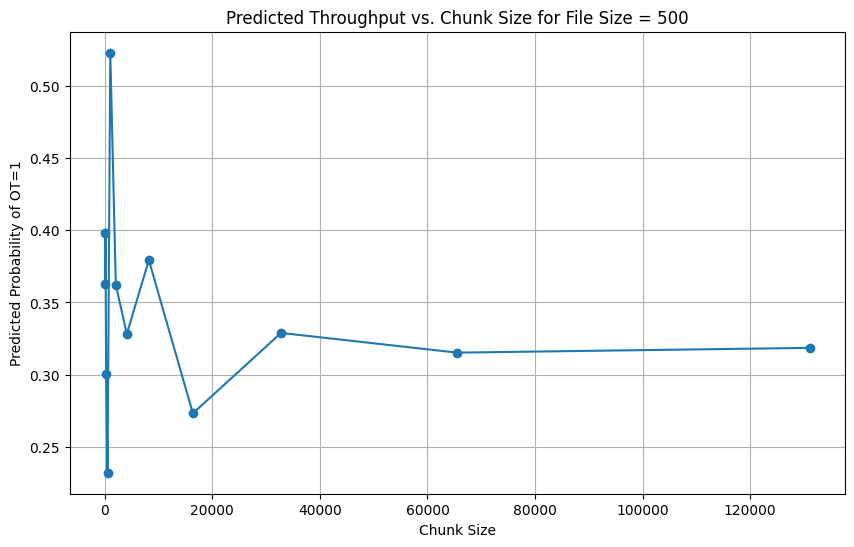

In [13]:
# Cell 11: Visualize predicted probability vs. chunk size for a fixed file size.
def plot_probabilities(model, file_size, candidate_chunks):
    probs = []
    for chunk in candidate_chunks:
        features = np.array([[file_size, chunk]])
        prob = model.predict_proba(features)[0][1]
        probs.append(prob)
    plt.figure(figsize=(10, 6))
    plt.plot(candidate_chunks, probs, marker='o')
    plt.xlabel('Chunk Size')
    plt.ylabel('Predicted Probability of OT=1')
    plt.title(f'Predicted Throughput vs. Chunk Size for File Size = {file_size}')
    plt.grid(True)
    plt.show()

# Plot the probabilities for the example file size.
plot_probabilities(rf_model, file_size_example, unique_chunks)

In [14]:
# prompt: write the code to save the model as .pkl

import pickle

# Save the trained model as a pickle file
filename = 'trained_model.pkl'
pickle.dump(rf_model, open(filename, 'wb'))

print(f"Model saved to {filename}")


Model saved to trained_model.pkl
